# Quick Dirac-3 Programming Tutorial

Entropy quantum computing (EQC) is a unique paradigm for optimization leveraging quantum Zeno effect. Most quantum and quantum-inspired programming models, including quantum annealing models are restricted to qubits. Dirac-3 hybrid quantum optimization machine, third generation of EQC, allows the use of qudits, which are units of quantum information taking more than 2 possible values. Be sure to read the [Qudit Basics](https://learn.quantumcomputinginc.com/learn/lessons/qudit-basics) to further understand the benefit of high dimensional encoding using qudits.

This tutorial serves as a quick starter guide, offering practical examples to help users familiarize themselves with the solver characteristics, execute simple examples an interpret the results from Dirac-3 effectively.

## Device - Dirac-3

Dirac-3 solves quadratic Hamiltonians of up to 949 variables. Third-order has a maximum size of 135 variables and fourth-order polynomials can have up to 30 variables. All variables can have joint terms. For more details, see the [user guide](https://quantumcomputinginc.com/learn/dirac-3/dirac-3-users-guide). 

## Tutorial Structure

The goal of this tutorial is to teach methods for extracting the most utility from Dirac-3. There are three different problems which we will use to demonstrate these techniques. 

1. The first is a simple example to help with understanding the domain of the qudits.
2. The second example is a polynomial which will be used for demonstrating how different values of the summation constraint can be used to change the solution of the problem.
4. The third example is a simple problem which, like the first, is minimized by setting one value to the whole quantity of $R$. The difference is that there are three solutions at optimality. Repeated runs will reveal different solutions.

First, we'll get our Python environment set up. We need `numpy` two methods to sample and evaluate quadratic Hamiltonians, respectively, and a connection to a device. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qci_client import QciClient
import os
os.environ["QCI_API_URL"] = api_url = "https://api.qci-prod.com"
os.environ["QCI_TOKEN"] = token = "" # REPLACE WITH YOUR TOKEN
qclient = QciClient(api_token=token, url=api_url)

The `sample_hamiltonian` method takes six required arguments. `C` and `J` are the linear and quadratic terms of the polynomial. These matrices are dense and the method converts into a sparse format for the `process_job` call. The `sum_constraint` parameter is a value which indicates the total returned given solution vector must add up to. The `schedule` parameter takes four different values, 1, 2, 3 or 4.

1. This the quickest execution. It has the lowest probability of high quality solutions.
2. The value 2 takes more time, likely a few seconds. It has a higher probability of finding good solutions.
3. This value will take up to many tens of seconds. The quality of these solutions is expected to he higher.
4. This is the longest running relaxation schedule. It takes up to multiple minutes of time and has the highest probability of quality solutions.

The `solution_precision` parameter is a value which indicates how granular a solution should be. Use a value of 1 for integer solutions. More precise values such as 0.1 or 0.05 are low precision decimals and the highest precision accepted is 0.00001. Specify a connected `EqcClient` in the `client` parameter. Suppress print statements in the call using a value of `True` for `suppress_output`.

In [2]:
def sample_hamiltonian(C : np.ndarray, J : np.ndarray, sum_constraint : float, schedule : int, solution_precision : float, client : QciClient):
    
    n = C.shape[0]
    H = np.hstack([C.reshape([n, 1]), J])
    ham_file = {"file_name": "qudit-tutorial-hame", "file_config": {"hamiltonian": {"data": H}}}
    file_id = client.upload_file(ham_file)["file_id"]
    job_tags = ["qudit-tutorial"]
    job_body = client.build_job_body(job_type="sample-hamiltonian", hamiltonian_file_id=file_id, 
                                     job_params={"sampler_type": "dirac-3", "nsamples": 1, "solution_precision": solution_precision,
                                                 "sum_constraint": sum_constraint, "relaxation_schedule": schedule}, job_tags=job_tags)
    response = client.process_job(job_type="sample-hamiltonian", job_body=job_body, wait=True)

    # total_device_time += resp["runtime"]
    return response
def get_results(response):
    if "results" in response and response["results"] is not None:
        results_file_config = response["results"]["file_config"]
        # results file config has one key, named by the job type detail
        assert len(results_file_config) == 1, "Unknown results format"
        results = list(results_file_config.values())[0]
    else:
        if "job_info" in response and "job_result" in response["job_info"]:
            details = response["job_info"]["job_result"]
        else:
            details = None
        raise RuntimeError(f"Execution failed. See details: {details}")
    return results

## Qudit Domain
EQC devices like Dirac-3 using qudits solve problems with qudits defined as $x_i\in[0, R]$ where $R$ is a summation constraint value. 

The first example shows the full range of the qudit domain. In this example, one variable will take on the total value of the summation constraint and the rest will take the value 0.

Note the `dtype` of `float32`. This is the digital precision for floating point numbers used in the gRPC protocol. A warning will be raised if higher precision decimal values are used.

In [3]:
h = np.array([
    [-1],
    [0],
    [0]
], dtype=np.float32
)
J= np.array([
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
], dtype=np.float32
)
h, J

(array([[-1.],
        [ 0.],
        [ 0.]], dtype=float32),
 array([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]], dtype=float32))

In [4]:
response = sample_hamiltonian(h, J, 400, 1, 0.1, qclient)
if "job_info" in response:
    print("Status:", response["job_info"]["details"]["status"])
    results = get_results(response)
    print("Energy:", results["energies"][0])
    print("Solution")
    print(results["solutions"][0])
    solution = np.array(results["solutions"][0])
    print("Solution Value (should match energy)", h.T@solution + solution.T@J@solution)
    x = np.array([400, 0, 0])
    print("Known ground state", h.T@x + x.T@J@x)
    print("With solution", x)
else:
    print(response)

Dirac allocation balance = 0
Job submitted job_id='65dff2f21e7c62f822901851'-: 2024/02/28 19:58:58
running: 2024/02/28 19:58:59
completed: 2024/02/28 19:59:46
Dirac allocation balance = 0
Status: completed
Energy: -400
Solution
[400, 0, 0]
Solution Value (should match energy) [-400.]
Known ground state [-400.]
With solution [400   0   0]



## Dynamic Range

Solution precision is dictated by the measurement sensitivity of the underlying photonics. Dirac-3.1 has a dynamic range of at least 23 dB. This means that values from the Hamiltonian which have an absolute magnitude smaller than approximately 1/200 the value of the largest magnitude may not be recognized within the device (will essentially be the same as 0) when encoding the Hamiltonian. In some cases, the device sensitivity is as high as 40 dB. This has an effect of making some solutions indistinguishable from each other. In practice, the higher dynamic range may be recognizable, but is not guaranteed. 

The device minimizes Hamiltonians using discrete levels, which do not necessarily have unit spacing. The number of levels is at least 200, but the device may reach up to 10,000 levels during any particular run, corresponding to 23 dB and 40 dB. Each level will have an incremental value based on the summation constraint, $R$. The qudit values will be within some error of a level which takes on a value $i\frac{R}{200}$ when the number of levels reached is equal to 200. $i$ is the level number. Level 0 is $0\left(\frac{R}{200}\right)$ and level 1 is $\frac{R}{200}$. 

Device sensitivity is not controlled by user inputs and so the number of levels should not be a part of a problem formulation. More details on this are available in the Dirac-3 User Guide.


## Summation Constraint

The summation constraint is required to be some value between 1 and 10,000. This restriction is a property of Dirac-3.1 and not EQC in general. This constraint is helpful in some models and a formulation hurdle in others. In all formulations of TSP, for instance, the sum of a final solution is known beforehand. A Hamiltonian cycle (another one of those confusing terminologies that shows up when mathematicians and physicists work together) has exactly $n$ edges, where $n$ is the number of nodes in a graph. This means that solving a TSP with Dirac-3 requires setting the sum constraint equal to the number of nodes in the graph.

Other cases where the sparsity or sum of the solution is not known before solving can be solved with a couple of different approaches.

### Machine Slack Qudits
When formulating a model, it can be advantageous to add slack variables. To use this method when setting a summation constraint, formulate the Hamiltonian like normal, then determine a lower bound and an upper bound on the sum of the qudit values. Introduce additional an additional qudit into the formulated model which can sum to the upper bound minus the lower bound. This additional variable in the model will be ignored in the solution. See some of the more indepth examples, like Max Cut, to understand slack qudits in action. 



### Minimizing a simple polynomial

Let $H(x)=-5x_1x_3-4x_2^2-10x_1-10x_3$. This polynomial has no lower bound, but within a finite domain, it does. If $\sum_i x_i = R$, then $H(s)$ has a minimum value which changes negatively with $R$ and changes the cardinality of $x$. At some value of $S$, all values greater force the minimization of $H(x)$ to have $x_1=x_3=0, x_2=R$. Below that point, $x_1=x_3=R/2,x_2=0$.

In [5]:
h = np.array([[-10.],
              [  0.],
              [-10.]], dtype=np.float32)
J = np.array([[0.,    0.,   -2.5],
              [0.,   -4.,    0. ],
              [-2.5,   0.,    0. ]], dtype=np.float32)
for S in [2, 3, 4, 5, 6, 7]:
    print("**********************************")
    print(f"S={S}")
    response = sample_hamiltonian(h, J, S, 3, 0.1, qclient)
    results = get_results(response)
    print("Status:", response["job_info"]["details"]["status"])
    results = get_results(response)
    print("Energy:", results["energies"][0])
    print("Solution")
    print(results["solutions"][0])
    print()

**********************************
S=2
Dirac allocation balance = 0
Job submitted job_id='65dff3241e7c62f822901852'-: 2024/02/28 19:59:48
running: 2024/02/28 19:59:50
completed: 2024/02/28 19:59:56
Dirac allocation balance = 0
Status: completed
Energy: -24.99830436706543
Solution
[0.9815806150436401, 1.0000000116860974e-07, 1.0184195041656494]

**********************************
S=3
Dirac allocation balance = 0
Job submitted job_id='65dff32f1e7c62f822901853'-: 2024/02/28 19:59:59
running: 2024/02/28 20:00:00
completed: 2024/02/28 20:00:06
Dirac allocation balance = 0
Status: completed
Energy: -41.234031677246094
Solution
[1.5565037727355957, 2.0000000233721948e-07, 1.4434959888458252]

**********************************
S=4
Dirac allocation balance = 0
Job submitted job_id='65dff3391e7c62f822901854'-: 2024/02/28 20:00:09
running: 2024/02/28 20:00:10
completed: 2024/02/28 20:00:16
Dirac allocation balance = 0
Status: completed
Energy: -59.988162994384766
Solution
[2.0486626625061035, 1.

For reference, here is a job response that is returned in JSON from the REST API

In [6]:
response

{'job_info': {'job_id': '65dff3571e7c62f822901857',
  'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization_continuous': {'hamiltonian_file_id': '65dff356fd7ff43e52669ab3'}},
   'device_config': {'dirac-3': {'num_samples': 1,
     'sum_constraint': 7,
     'relaxation_schedule': 3}}},
  'job_status': {'submitted_at_rfc3339nano': '2024-02-29T03:00:39.435Z',
   'queued_at_rfc3339nano': '2024-02-29T03:00:39.436Z',
   'running_at_rfc3339nano': '2024-02-29T03:00:40.249Z',
   'completed_at_rfc3339nano': '2024-02-29T03:00:46.68Z'},
  'job_result': {'file_id': '65dff35efd7ff43e52669ab5', 'device_usage_s': 1},
  'details': {'status': 'completed'}},
 'results': {'file_id': '65dff35efd7ff43e52669ab5',
  'num_parts': 1,
  'num_bytes': 256,
  'file_config': {'normalized_qudit_hamiltonian_optimization_continuous_results': {'counts': [1],
    'energies': [-196],
    'solutions': [[1.0000000116860974e-07, 7, 0]]}}}}

## Degeneracy Demonstration

Dirac-3 will return various solutions to a problem with multiple solutions near the optimal value. This is supporting evidence for the existence of superposition honed through interference in the device.

Let's see what happens with a clearly degenerate problem. Take the first example modified to give the same weight to all the linear terms. Each solution: `[S, 0, 0]`, `[0, S, 0]` and `[0, 0, S]` give the same value for the Hamiltonian.

In [7]:
h = np.array([[-1],
              [-1],
              [-1]], dtype=np.float32)
J = np.array([[0, 1, 1],
              [1, 0, 1],
              [1, 1, 0]], dtype=np.float32)


Dirac allocation balance = 0
Job submitted job_id='65dff3611e7c62f822901858'-: 2024/02/28 20:00:49
completed: 2024/02/28 20:00:50
Dirac allocation balance = 0
Dirac allocation balance = 0
Job submitted job_id='65dff3651e7c62f822901859'-: 2024/02/28 20:00:53
completed: 2024/02/28 20:00:54
Dirac allocation balance = 0
Dirac allocation balance = 0
Job submitted job_id='65dff3691e7c62f82290185a'-: 2024/02/28 20:00:57
completed: 2024/02/28 20:00:59
Dirac allocation balance = 0
Dirac allocation balance = 0
Job submitted job_id='65dff36d1e7c62f82290185b'-: 2024/02/28 20:01:01
completed: 2024/02/28 20:01:03
Dirac allocation balance = 0
Dirac allocation balance = 0
Job submitted job_id='65dff3711e7c62f82290185c'-: 2024/02/28 20:01:05
completed: 2024/02/28 20:01:07
Dirac allocation balance = 0
Dirac allocation balance = 0
Job submitted job_id='65dff3751e7c62f82290185d'-: 2024/02/28 20:01:09
completed: 2024/02/28 20:01:11
Dirac allocation balance = 0
Dirac allocation balance = 0
Job submitted job

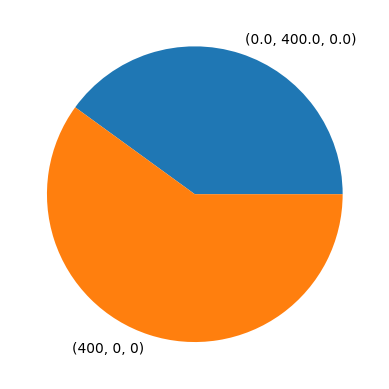

In [8]:
super_test = {}
for i in range(10):
    response = sample_hamiltonian(h, J, 400, 1, 0.1, qclient)
    results = get_results(response)
    solution = [round(v, 1) for v in results["solutions"][0]]
    solution = tuple(solution)
    if solution in super_test:
        super_test[solution] += 1
    else:
        super_test[solution] = 1
print("Solution           | Frequency")
for solution in super_test:
    print(solution, "  ", "*"*super_test[solution])
labels = list(super_test.keys())
sizes = [super_test[key] for key in labels]
fig, ax = plt.subplots()
patches, labels = ax.pie(sizes, labels=labels)